### Questions: 
1. Am i right that the epsilon-insensitive loss (standard SVR) is the L1 loss, while the squared epsilon-insensitive loss ('squared_epsilon_insensitive') is the L2 loss?
2. if yes, than we can use L1 as loss function for SVR, right? 


### SVM regressioin implementation

Data and plotting approach was taken from:
https://github.com/tomsharp/SVR/blob/master/SVR.ipynb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from numpy import linalg as la

In [3]:
df = pd.read_csv('Boston Housing Prices.csv')

In [4]:
df.head()

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
0,Nahant,2011,-70.955002,42.255001,0.00632,18.0,2.31,no,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98,24.000000
1,Swampscott,2021,-70.949997,42.287498,0.02731,0.0,7.07,no,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14,21.600000
2,Swampscott,2022,-70.935997,42.283001,0.02729,0.0,7.07,no,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03,34.700001
3,Marblehead,2031,-70.928001,42.292999,0.03237,0.0,2.18,no,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94,33.400002
4,Marblehead,2032,-70.921997,42.298000,0.06905,0.0,2.18,no,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33,36.200001


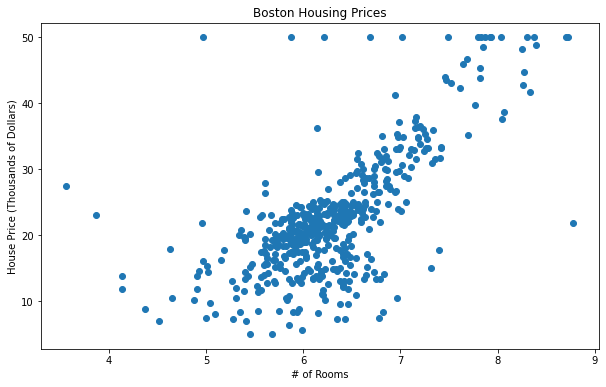

In [70]:
plt.figure(figsize=(10,6))
plt.scatter(x=df['rooms'], y=df['cmedv'])
plt.xlabel('# of Rooms')
plt.ylabel('House Price (Thousands of Dollars)')
plt.title('Boston Housing Prices')
plt.show()

In [74]:
X = np.array(df['rooms']).reshape(-1,1)
y = np.array(df['cmedv']).reshape(-1,1)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

### Loss function

slide 6 or in preso marked as 64:
http://vision.psych.umn.edu/users/schrater/schrater_lab/courses/PattRecog09/RegressionII.pdf

![image.png](loss_function.png)

In [85]:
from numpy import linalg as la
class svr_grd():
    '''
    class can handle only 1 feature to train
    in case when feature set is bigger, cpde adjustments must be done
    '''
    def __init__(self, epsilon, n_epochs, C=0.01, lr=0.01):
        self.epsilon = epsilon # the epsilon-insensitive loss, i.e. errors of less than  are ignored.
        self.C = C # the penalty term C controls the strengh of this penalty, and as a result, acts as an inverse regularization parameter 
        self.lr = lr 
        self.n_epochs = n_epochs
        
    def fit(self, X, y):
        
        # random initialization
        self.W = np.random.randn(X.shape[1], 1)/np.sqrt(X.shape[1]) # n feature weights
        #self._params = np.ones((num_features,num_targets))
        self.W0 = 0
        self.y = y
        self.loss_res = []
        m = int(len(y))
        
        for epoch in range(self.n_epochs):
            
            y_hat = X@self.W + self.W0
            loss = 1/2 * np.sum(self.W * self.W) + self.C * (np.sum(np.abs(y - y_hat)-self.epsilon)/ m)
            self.loss_res.append(loss)
            # derivative of loss function w.r.t to w and w0                                       
            gradient_W = self.W - self.C/m * np.sum((y - y_hat)/np.abs(y - y_hat) @ X)
            gradient_W0 = -self.C/m * np.sum((y - y_hat)/np.abs(y - y_hat))                                       
            self.W -= self.lr * gradient_W
            self.W0-= self.lr * gradient_W0  
                    
        return self.loss_res , self.W, self.W0
    def predict(self, X, w, w0):
        y_hat = X@w + w0
        return y_hat

In [86]:
model = svr_grd(5,150)

In [87]:
loss_res, w , w0 = model.fit(X_train, y_train)

In [88]:
loss_res = np.array(loss_res).flatten()

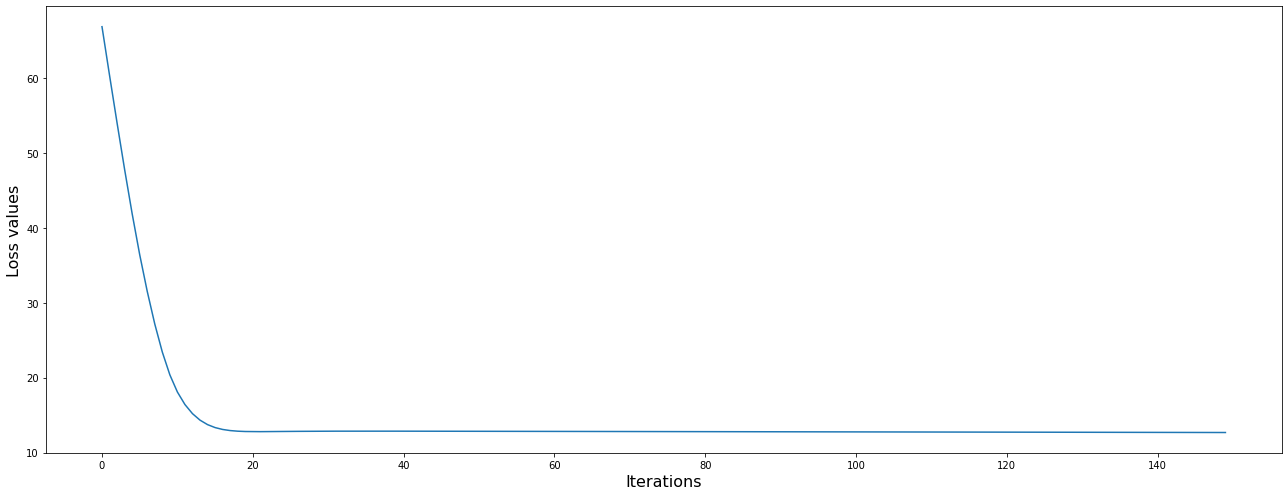

In [89]:
plt.figure(figsize = (18,7))
plt.plot(loss_res)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Loss values", fontsize=16)
plt.tight_layout()
plt.show()

In [90]:
predictions = model.predict(X_test, w, w0)

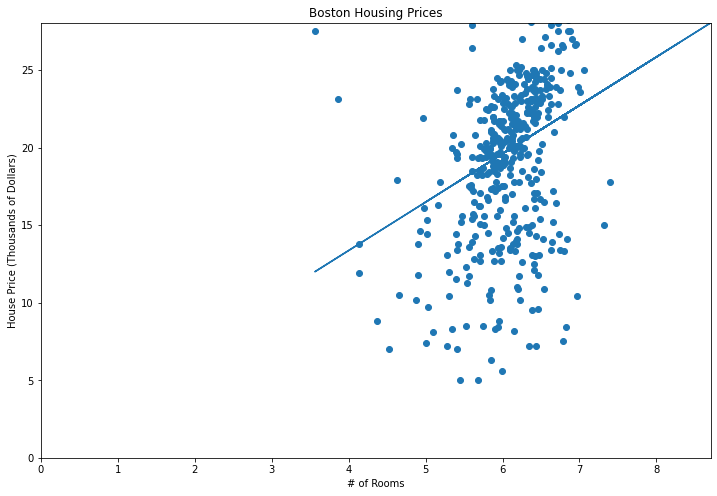

In [91]:
plt.figure(figsize=(12,8))
plt.scatter(x=df['rooms'], y=df['cmedv'])
plt.plot(X_test,predictions.flatten())
plt.xlim([0, max(X_test)])
plt.ylim([0, max(predictions.flatten())])
plt.xlabel('# of Rooms')
plt.ylabel('House Price (Thousands of Dollars)')
plt.title('Boston Housing Prices')
plt.show()

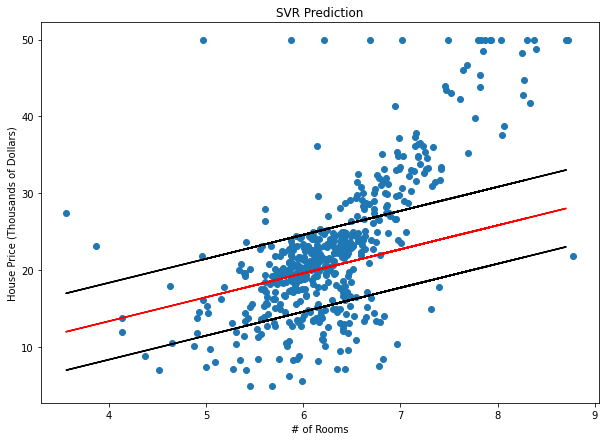

In [92]:
# Plot outputs
eps = 5
plt.figure(figsize=(10,7))
plt.scatter(x=df['rooms'], y=df['cmedv'])
plt.plot(X_test, predictions.flatten(), color='red')
plt.plot(X_test, predictions.flatten()+eps, color='black')
plt.plot(X_test, predictions.flatten()-eps, color='black')
plt.xlabel('# of Rooms')
plt.ylabel('House Price (Thousands of Dollars)')
plt.title('SVR Prediction')
plt.show()

In [93]:
mae = mean_absolute_error(y_test, predictions.flatten())
print("MAE = ${:,.2f}".format(1000*mae))

MAE = $5,628.94


### Compare with sklearn 

In [94]:
def svr_results(y_test, X_test, fitted_svr_model):
    
    print("C: {}".format(fitted_svr_model.C))
    print("Epsilon: {}".format(fitted_svr_model.epsilon))
    
    print("Intercept: {:,.3f}".format(fitted_svr_model.intercept_[0]))
    print("Coefficient: {:,.3f}".format(fitted_svr_model.coef_[0]))
    
    mae = mean_absolute_error(y_test, fitted_svr_model.predict(X_test))
    print("MAE = ${:,.2f}".format(1000*mae))
    
    perc_within_eps = 100*np.sum(y_test - fitted_svr_model.predict(X_test) < eps) / len(y_test)
    print("Percentage within Epsilon = {:,.2f}%".format(perc_within_eps))
    
    # Plot outputs
    plt.figure(figsize=(10,7))
    plt.scatter(x=df['rooms'], y=df['cmedv'])
    plt.plot(X_test, fitted_svr_model.predict(X_test), color='red')
    plt.plot(X_test, fitted_svr_model.predict(X_test)+eps, color='black')
    plt.plot(X_test, fitted_svr_model.predict(X_test)-eps, color='black')
    plt.xlabel('# of Rooms')
    plt.ylabel('House Price (Thousands of Dollars)')
    plt.title('SVR Prediction')
    plt.show()

In [95]:
eps = 5
svr = LinearSVR(epsilon=eps, C=0.01, fit_intercept=True)

In [96]:
svr.fit(X_train, y_train)

LinearSVR(C=0.01, epsilon=5)

C: 0.01
Epsilon: 5
Intercept: 0.369
Coefficient: 3.136
MAE = $5,783.63
Percentage within Epsilon = 73.53%


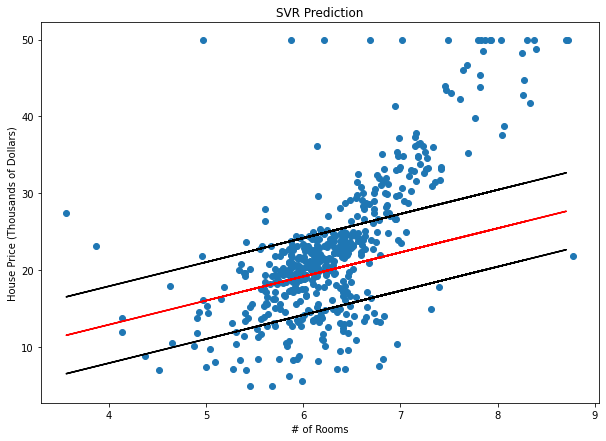

In [97]:
svr_results(y_test, X_test, svr)

In [100]:
X = np.array(df[['rooms','crime','distance']]).reshape(-1,3)
y = np.array(df['cmedv']).reshape(-1,1)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

In [102]:
model = svr_grd(5,150)

In [103]:
loss_res, w , w0 = model.fit(X_train, y_train)

In [108]:
loss_res = np.array(loss_res).flatten()

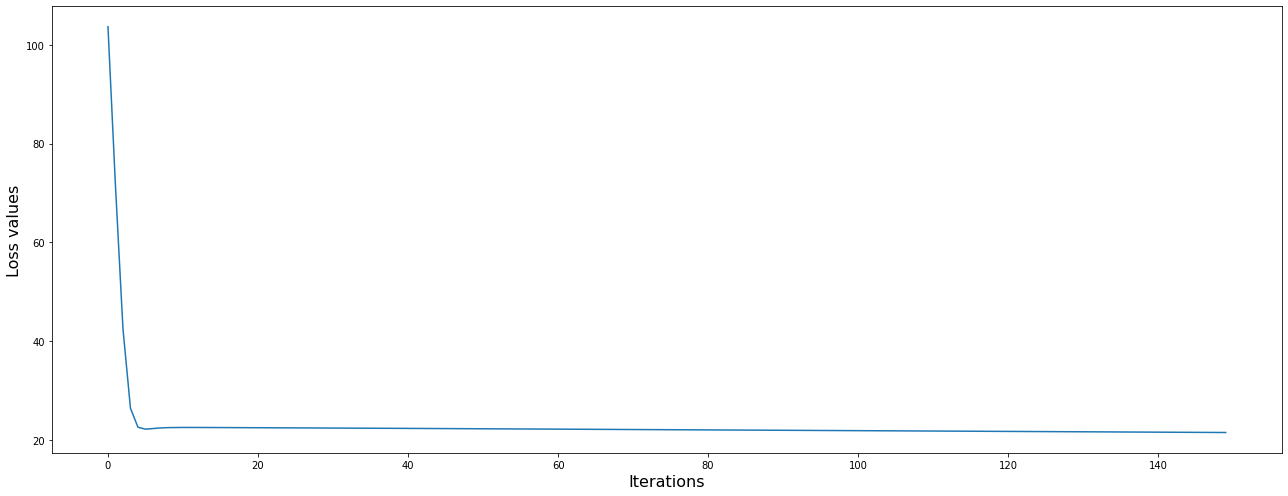

In [109]:
plt.figure(figsize = (18,7))
plt.plot(loss_res)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Loss values", fontsize=16)
plt.tight_layout()
plt.show()

In [105]:
predictions = model.predict(X_test, w, w0)

In [106]:
mae = mean_absolute_error(y_test, predictions.flatten())
print("MAE = ${:,.2f}".format(1000*mae))

MAE = $10,171.26
